## Yelp Ratings & Restaurant Attributes in Orange County

This notebook walks through our full analysis workflow:


*   Where we obtained the data (Yelp Review Insights for 50 restaurants across 5 cuisines)
*   How we loaded and prepared the data
*   Exploratory data analysis and visualizations
*   ANOVA tests
*   Pearson correlation, simple regression (with r²), and multiple regression
*   Key insights and supporting plots







In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy import stats
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Data source and loading

We manually compiled attribute-level summary data from Yelp’s “Review Insights” for 50 restaurants (10 each from Vietnamese, Korean, Japanese, Mexican, and Italian cuisines) in Orange County into `Yelp Review.xlsx`. Below, we load this dataset into Python.

In [ ]:
# Inspect and describe the data
df = pd.read_excel("Yelp Review.xlsx")
df.head()

,index,name,cuisine,location,price,overall_num_review,overall_rating,ambience_num_review,ambience_rating,food_num_review,food_rating,service_num_review,service_rating
0,0,VOX Kitchen,Vietnamese,Fountain Valley,$$,7964,4.5,846,0.81,1677,0.84,1194,0.83
1,1,NEP Café,Vietnamese,Fountain Valley,$$,4537,4.5,1035,0.86,1870,0.83,1314,0.83
2,2,Brodard Restaurant,Vietnamese,Fountain Valley,$$,3924,3.8,423,0.68,908,0.78,583,0.63
3,3,Pho 79 Restaurant,Vietnamese,Garden Grove,$$,3769,4.2,199,0.56,581,0.79,381,0.48
4,4,Oc & Lau Restaurant,Vietnamese,Graden Grove,$$,3273,4.0,267,0.57,560,0.80,363,0.71


Variable definitions

*   name: Restaurant name
*   cuisine: Cuisine type (Vietnamese, Korean, Japanese, Mexican, or Italian)
*   location: City in Orange County where the restaurant is located
*   price: Restaurant’s price range
*   overall_num_review: Total number of reviews for the restaurant
*   ambience_num_review: Total number of reviews mentioning “ambience”
*   ambience_rating: Proportion of positive reviews mentioning “ambience”
*   food_num_review: Total number of reviews mentioning “food quality”
*   food_rating: Proportion of positive reviews mentioning “food quality”
*   service_num_review: Total number of reviews mentioning “service”
*   service_rating: Proportion of positive reviews mentioning “service”

In [ ]:
df = df.drop(['index', 'location'], axis=1)
attribute = ['ambience_rating', 'food_rating', 'service_rating']
cuisine = ['Vietnamese', 'Korean', 'Japanese', 'Mexican', 'Italian']

# **Exploratory Data Analysis (EDA)**

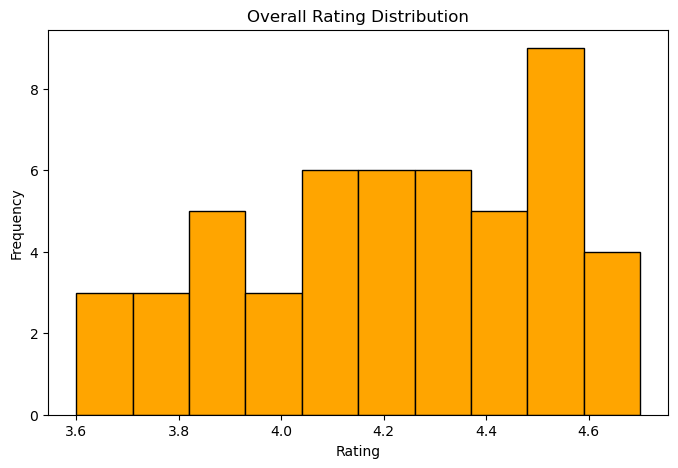

In [ ]:
# General Overall Rating Frequency

plt.figure(figsize=(8,5))
plt.hist(df["overall_rating"], color="orange", edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Overall Rating Distribution")
plt.show()

Most restaurants are rated 4.0 or higher, with ratings randing from about 3.6 to 5 stars.

Text(0, 0.5, 'Rating')

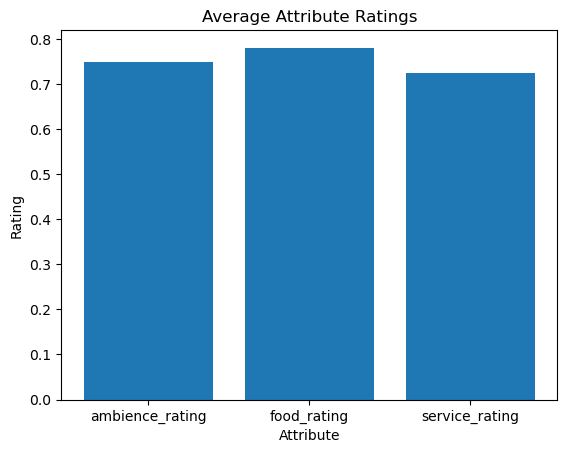

In [ ]:
# General Average Attribute Rating

avg_ambience = df['ambience_rating'].mean()
avg_food = df['food_rating'].mean()
avg_service = df['service_rating'].mean()

avgs = [avg_ambience, avg_food, avg_service]

plt.bar(attribute, avgs)
plt.title('Average Attribute Ratings')
plt.xlabel('Attribute')
plt.ylabel('Rating')

Food quality rends to have the highest positibe mention proportion overall.

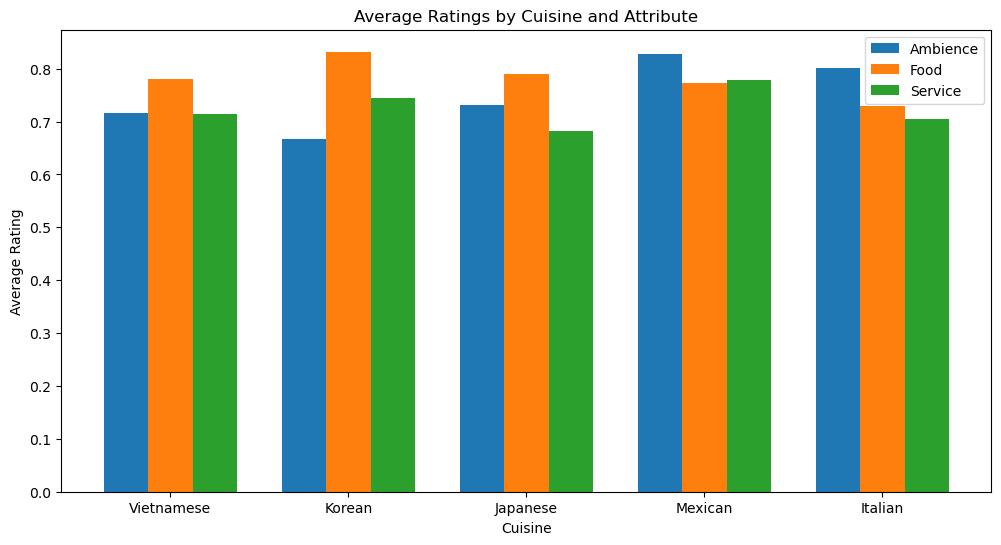

In [ ]:
# General Average Ratings by Cuisine and Attribute

data = {}
for cui in cuisine:
    cui_data = df[df['cuisine'] == cui]
    data[cui] = [cui_data[att].mean() for att in attribute]

ambience_avgs = [data[cui][0] for cui in cuisine]
food_avgs = [data[cui][1] for cui in cuisine]
service_avgs = [data[cui][2] for cui in cuisine]

x = np.arange(len(cuisine))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(x - width, ambience_avgs, width, label='Ambience')
bar2 = ax.bar(x, food_avgs, width, label='Food')
bar3 = ax.bar(x + width, service_avgs, width, label='Service')

ax.set_xlabel('Cuisine')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings by Cuisine and Attribute')
ax.set_xticks(x)
ax.set_xticklabels(cuisine)
ax.legend()

Ambience appears slightly higher for Italian and Mexican restaurants in the visualization, while food quality appears higher for Vietnamese, Korean, and Japanese restaurants.

In [ ]:
# Prep mean attribute values by cuisine for the barplot

tags_by_cuisine = df.groupby("cuisine")[attribute].mean()
tags_by_cuisine_df = pd.DataFrame(tags_by_cuisine).reset_index()
tags_reviews = df[attribute].mean()
tags_reviews_df = pd.DataFrame(tags_reviews).reset_index()

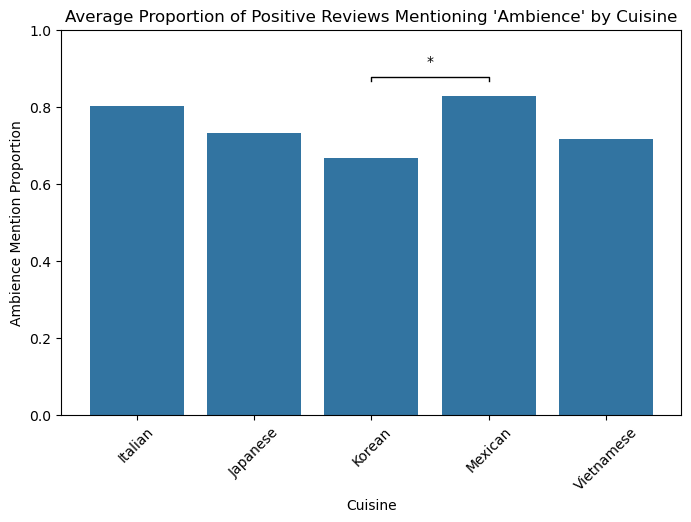

In [ ]:
# Plot average ambience_rating by cuisine

plt.figure(figsize=(8,5))
ax = sns.barplot(data = tags_by_cuisine_df, x = "cuisine", y = "ambience_rating")
plt.xlabel("Cuisine")
plt.xticks(rotation=45)
plt.ylabel("Ambience Mention Proportion")
plt.title("Average Proportion of Positive Reviews Mentioning 'Ambience' by Cuisine")
plt.ylim(0.0, 1.0)

# Add significance bar between Korean and Mexican restaurant (*) - identified later from ANOVA results
y_max = tags_by_cuisine_df['ambience_rating'].max()
y_line = y_max + 0.04
y_text = y_line + 0.04

x2, x3 = 2, 3
ax.plot([x2, x2, x3, x3], [y_line, y_line+0.01, y_line+0.01, y_line], lw=1.0, color = "black")
ax.text((x2 + x3)*0.5, y_text, "*", ha='center')
plt.show()

From the plot, Mexican restaurants show the highest ambience mention proportion, while Korean restaurants appear lowest. These differences are explored formally in the ANOVA section later in the notebook.

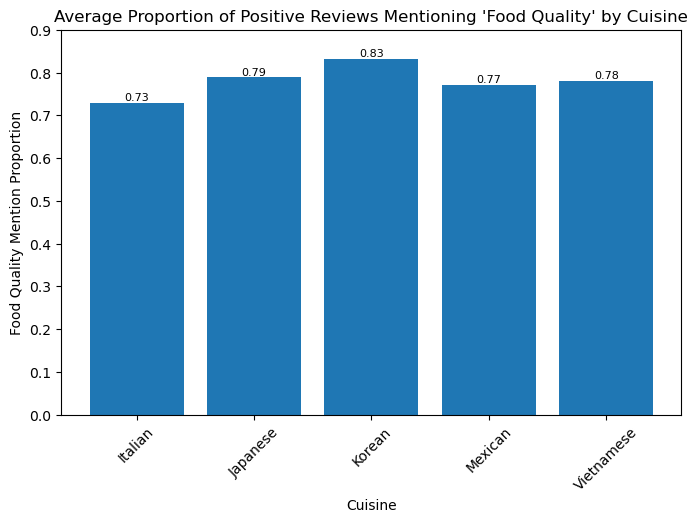

In [ ]:
# Plot average food_rating by cuisine

plt.figure(figsize=(8,5))
ax = sns.barplot(data = tagsD_by_cuisine_df, x = "cuisine", y = "food_rating", color = "skyblue")
ax.bar_label(ax.containers[0],fmt="%.2f", fontsize=8)

plt.bar(tags_by_cuisine_df["cuisine"], tags_by_cuisine_df["food_rating"])
plt.xlabel("Cuisine")
plt.xticks(rotation=45)
plt.ylabel("Food Quality Mention Proportion")
plt.title("Average Proportion of Positive Reviews Mentioning 'Food Quality' by Cuisine")
plt.ylim(0.0, 0.9)
plt.show()

The cuisines show small differences in food-quality mentions, with Korean appearing the highest. ANOVA later tests whether these differences are meaningful.

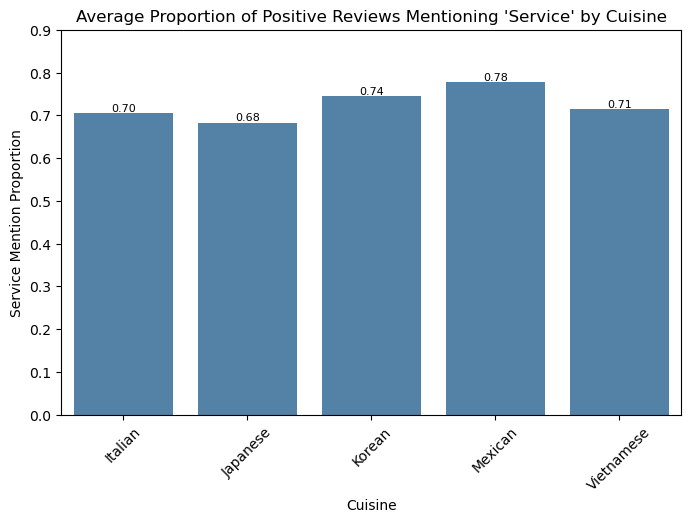

In [ ]:
# Plot average service_rating by cuisine

plt.figure(figsize=(8,5))
ax = sns.barplot(data =tags_by_cuisine_df, x = "cuisine", y = "service_rating", color = "steelblue")
ax.bar_label(ax.containers[0],fmt="%.2f", fontsize=8)
plt.xlabel("Cuisine")
plt.xticks(rotation=45)
plt.ylabel("Service Mention Proportion")
plt.title("Average Proportion of Positive Reviews Mentioning 'Service' by Cuisine")
plt.ylim(0.0,0.9)
plt.show()

Service mentions vary slightly across cuisines, with Mexican appearing the highest.

(0.0, 5.0)

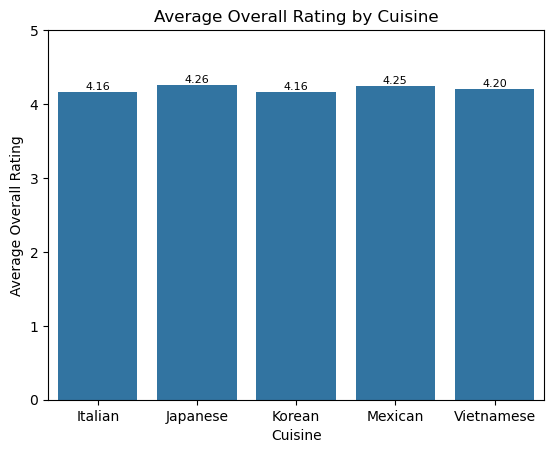

In [ ]:
# Average overall rating for each cuisine of restaurants
overall_average_rating = df.groupby("cuisine")['overall_rating'].mean()

overall_average_rating_df = pd.DataFrame(overall_average_rating).reset_index()
overall_average_rating_df

# Plot average ratings by cuisine

ax = sns.barplot(data = overall_average_rating_df, x = "cuisine", y = "overall_rating")
ax.bar_label(ax.containers[0],fmt="%.2f", fontsize=8)
plt.xlabel("Cuisine")
plt.ylabel("Average Overall Rating")
plt.title("Average Overall Rating by Cuisine")
plt.ylim(0,5)

Overall ratings appear consistent across all cuisines.

# **ANOVA Test**

In [ ]:
# Check normality assumption for ANOVA

# Test normality of ambience ratings using Shapiro-Wilk
ambience_rating = df['ambience_rating']

statistic, p_value = shapiro(ambience_rating)
print("Statistic:", statistic)
print("P-value:", p_value)

# Ambience NOT normally distributed so we need to transform the data
# Use arcisne square root transformation

df['ambience_rating_transformed'] = np.arcsin(np.sqrt(df['ambience_rating']))

# Rerun Shapiro-Wilk test on the transformed data to see if it normal now

ambience_rating_transformed = df['ambience_rating_transformed']

statistic, p_value = shapiro(ambience_rating_transformed)
print("Statistic transformed:", statistic)
print("P-value transformed :", p_value)

# Transformed data is now normally distributed

Statistic: 0.9474189965134278
P-value: 0.026752360712632057
Statistic transformed: 0.9713023279173084
P-value transformed : 0.2612704028736359


In [ ]:
# ANOVA test for whether average ambience ratings differ across cuisines

Italian = df[df['cuisine'] == "Italian"]['ambience_rating_transformed']
Japanese = df[df['cuisine']== 'Japanese']['ambience_rating_transformed']
Korean = df[df['cuisine']== 'Korean']['ambience_rating_transformed']
Mexican = df[df['cuisine']== 'Mexican']['ambience_rating_transformed']
Vietnamese = df[df['cuisine']=="Vietnamese"]['ambience_rating_transformed']

f_statistic, p_value = f_oneway(Italian, Japanese, Korean, Mexican, Vietnamese)
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# Yes: p-value < 0.05

# Tukey's Post Hoc test to see where that difference lies
tukey = pairwise_tukeyhsd(endog=df['ambience_rating'],groups=df['cuisine'], alpha=0.05)
print(f'Tukey:{tukey}')

# Only a significant differences in ratings of ambience between Korean and Mexican restaurants

F-statistic: 3.4294203610214207
P-value: 0.0157148713744483
Tukey:   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2   meandiff p-adj   lower  upper  reject
---------------------------------------------------------
 Italian   Japanese    -0.07 0.6331 -0.2124 0.0724  False
 Italian     Korean   -0.134 0.0742 -0.2764 0.0084  False
 Italian    Mexican    0.026  0.985 -0.1164 0.1684  False
 Italian Vietnamese   -0.084 0.4588 -0.2264 0.0584  False
Japanese     Korean   -0.064 0.7066 -0.2064 0.0784  False
Japanese    Mexican    0.096 0.3244 -0.0464 0.2384  False
Japanese Vietnamese   -0.014 0.9986 -0.1564 0.1284  False
  Korean    Mexican     0.16 0.0207  0.0176 0.3024   True
  Korean Vietnamese     0.05 0.8551 -0.0924 0.1924  False
 Mexican Vietnamese    -0.11 0.2005 -0.2524 0.0324  False
---------------------------------------------------------


In [ ]:
# Check normality assumption for ANOVA

# Test normality of food raings using Shapiro-Wilk
food_rating = df['food_rating']

statistic, p_value = shapiro(food_rating)
print("Statistic:", statistic)
print("P-value:", p_value)

# Assume normal distribution

Statistic: 0.9558569623931149
P-value: 0.05964203497641432


In [ ]:
# ANOVA test for whether average food ratings differ across cuisines

Italian_3= df[df['cuisine'] == "Italian"]['food_rating']
Japanese_3 = df[df['cuisine']== 'Japanese']['food_rating']
Korean_3 = df[df['cuisine']== 'Korean']['food_rating']
Mexican_3 = df[df['cuisine']== 'Mexican']['food_rating']
Vietnamese_3 = df[df['cuisine']=="Vietnamese"]['food_rating']

f_statistic, p_value = f_oneway(Italian_3, Japanese_3, Korean_3, Mexican_3, Vietnamese_3)
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# p > 0.05 -> No significant differences in food rating between cusiines

F-statistic: 2.275641263595529
P-value: 0.07582479387051881


In [ ]:
# Check normality assumption for ANOVA

# Test normality of service raings using Shapiro-Wilk
service_rating = df['service_rating']

statistic, p_value = shapiro(service_rating)
print("Statistic:", statistic)
print("P-value:", p_value)

# Assume normal distribution

Statistic: 0.9790344034123633
P-value: 0.5119943451030557


In [ ]:
# ANOVA test for whether average service ratings differ across cuisines

I_3 = df[df['cuisine'] == "Italian"]['service_rating']
J_3 = df[df['cuisine']== 'Japanese']['service_rating']
K_3 = df[df['cuisine']== 'Korean']['service_rating']
M_3 = df[df['cuisine']== 'Mexican']['service_rating']
V_3 = df[df['cuisine']=="Vietnamese"]['service_rating']

f_statistic, p_value = f_oneway(I_3, J_3, K_3, M_3, V_3)
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# p > 0.05 -> No significant differences in service rating between cusiines

F-statistic: 0.7417684032394539
P-value: 0.5685629090191909


In [ ]:
# ANOVA test for whether average overall ratings differ across cuisines

# Create groups for each cuisine
Italian = df[df['cuisine'] == "Italian"]['overall_rating']
Japanese = df[df['cuisine']== 'Japanese']['overall_rating']
Korean = df[df['cuisine']== 'Korean']['overall_rating']
Mexican = df[df['cuisine']== 'Mexican']['overall_rating']
Vietnamese = df[df['cuisine']=="Vietnamese"]['overall_rating']

# RUn one-way ANOVA on overall ratings
f_statistic, p_value = f_oneway(Italian, Japanese, Korean, Mexican, Vietnamese)
print("F-statistic:", f_statistic)
print("P-value:", p_value)

# p > 0.05 -> no significant differences in overall ratings across cuisines

F-statistic: 0.26327944572748246
P-value: 0.8999691325685865


**OVERALL FINDINGS:** Only significant differences emerged in ambience between Korean and Mexican restaurants. All other pair-wise differences showed non-significant differences across ambience, food quality, and service.

# **Pearson Correlation Analysis**

In [ ]:
# Compute Pearson correlations to measure how strongly each attribute (ambience, food, service) is associated with overall rating, both overall and by cuisine

print("Overall Rating")

for att in attribute:
    corr, p = stats.pearsonr(df[att], df['overall_rating'])
    print(att.replace('_rating', '').title())
    print("r =", corr.round(4))
    print("p =", p.round(10))
print()

print("Rating by Cuisine")

for cui in cuisine:
    cui_df = df[df['cuisine'] == cui]
    print()
    print(cui)

    for att in attribute:
        corr, p = stats.pearsonr(cui_df[att], cui_df['overall_rating'])
        print(att.replace('_rating', '').title(), "r =", corr.round(4), "p =", p.round(4))

Overall Rating
Ambience
r = 0.4795
p = 0.0004260988
Food
r = 0.7064
p = 1e-08
Service
r = 0.5954
p = 5.0985e-06

Rating by Cuisine

Vietnamese
Ambience r = 0.5867 p = 0.0746
Food r = 0.6686 p = 0.0346
Service r = 0.4325 p = 0.2119

Korean
Ambience r = 0.713 p = 0.0206
Food r = 0.5137 p = 0.1288
Service r = 0.455 p = 0.1864

Japanese
Ambience r = 0.4241 p = 0.2219
Food r = 0.9106 p = 0.0003
Service r = 0.6588 p = 0.0383

Mexican
Ambience r = 0.3669 p = 0.2969
Food r = 0.9174 p = 0.0002
Service r = 0.8544 p = 0.0016

Italian
Ambience r = 0.6714 p = 0.0335
Food r = 0.8727 p = 0.001
Service r = 0.689 p = 0.0275


Overall Pearson Correlation Scatter Plots


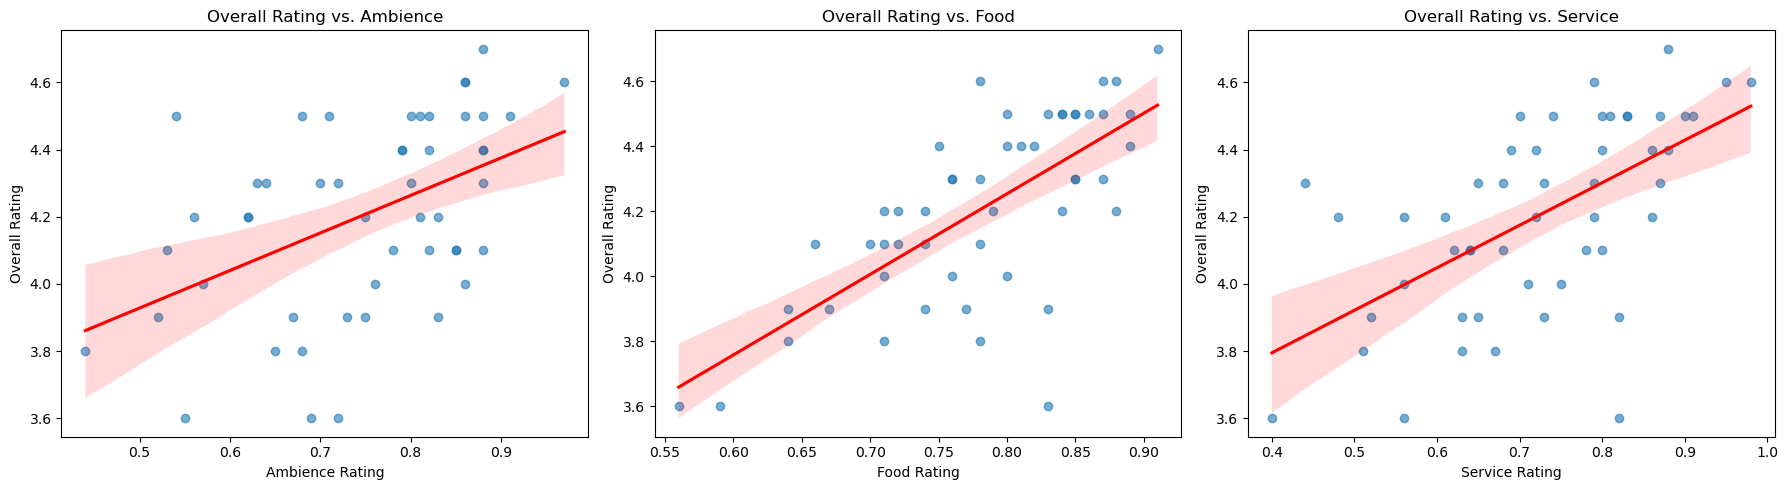


Cuisine-Specific Pearson Correlation Scatter Plots


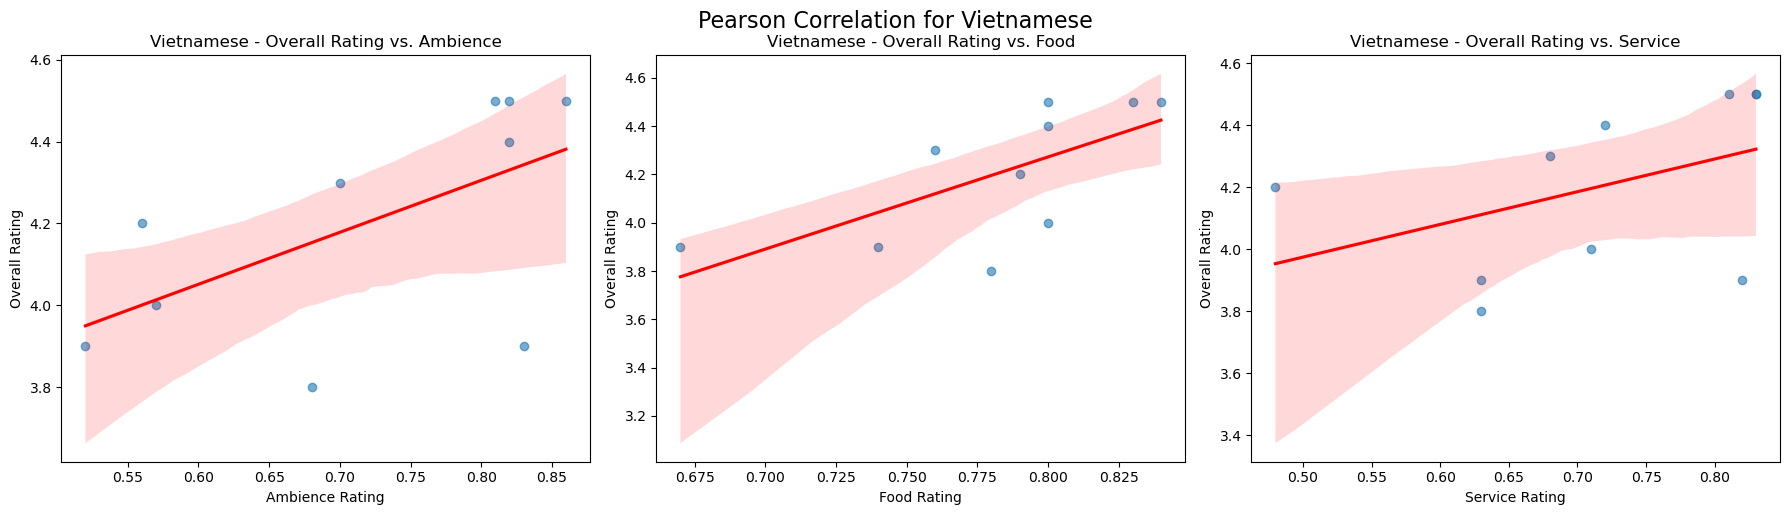

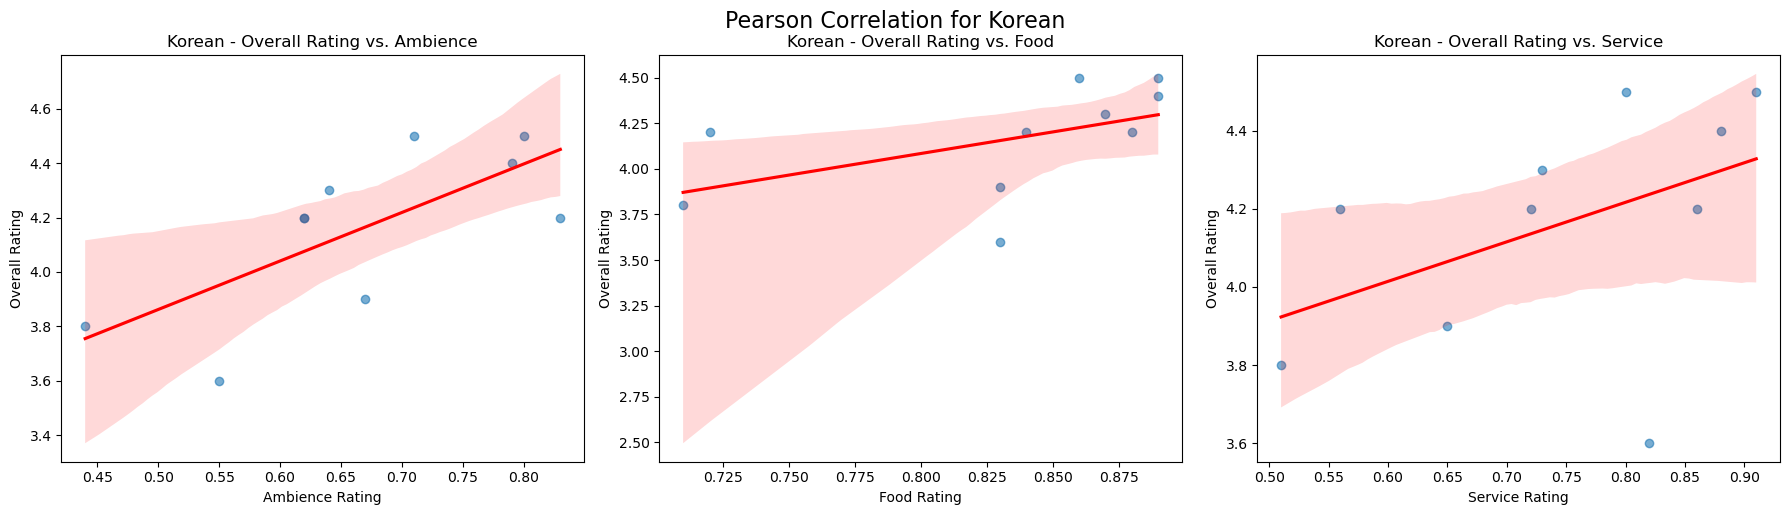

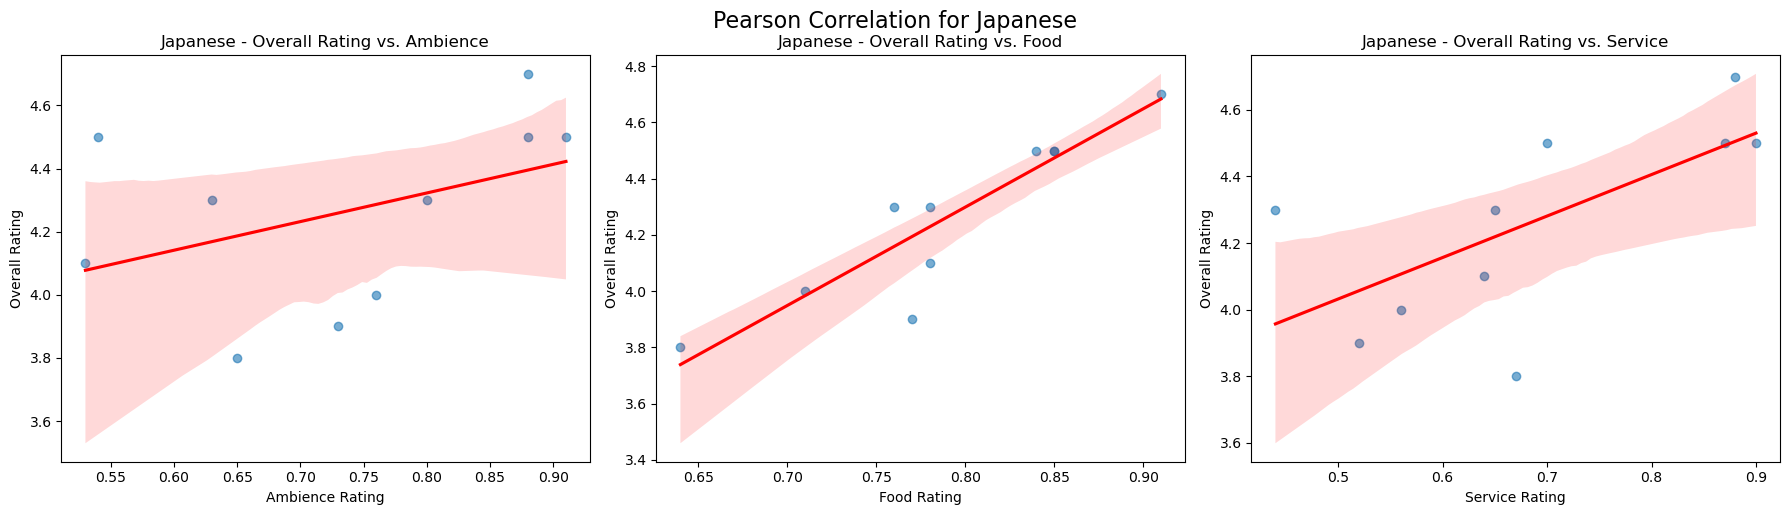

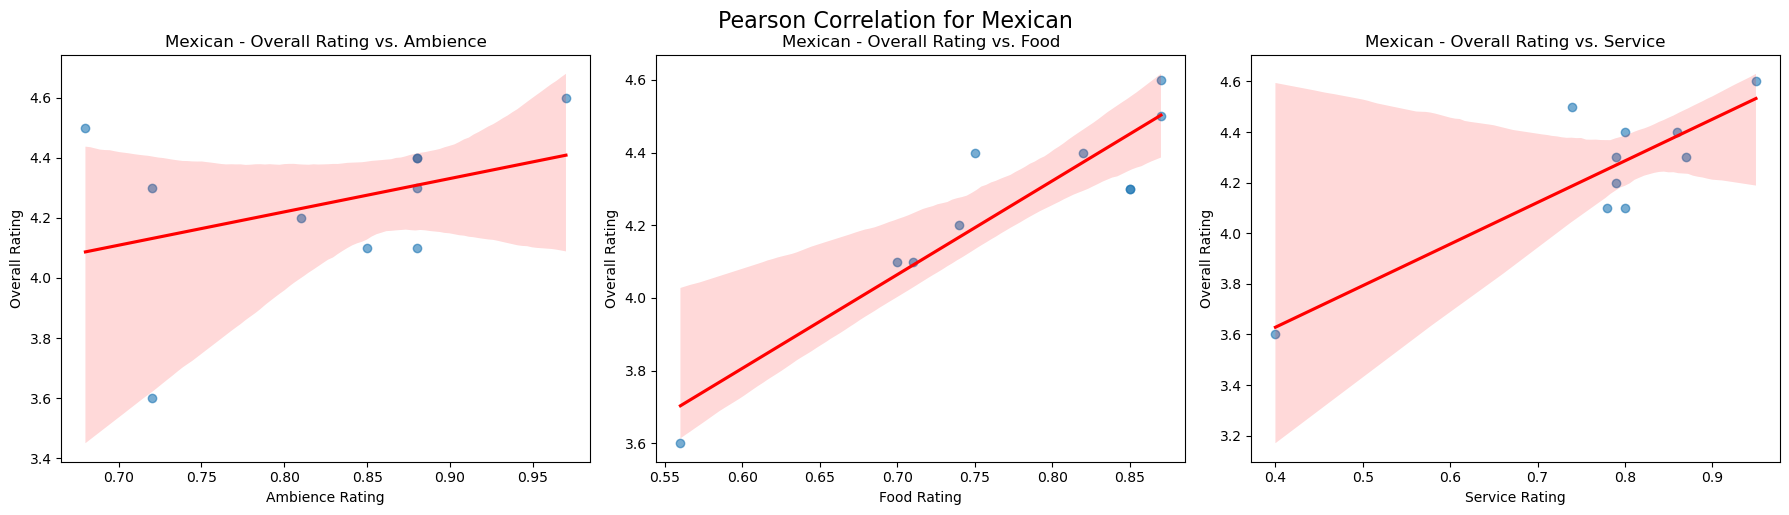

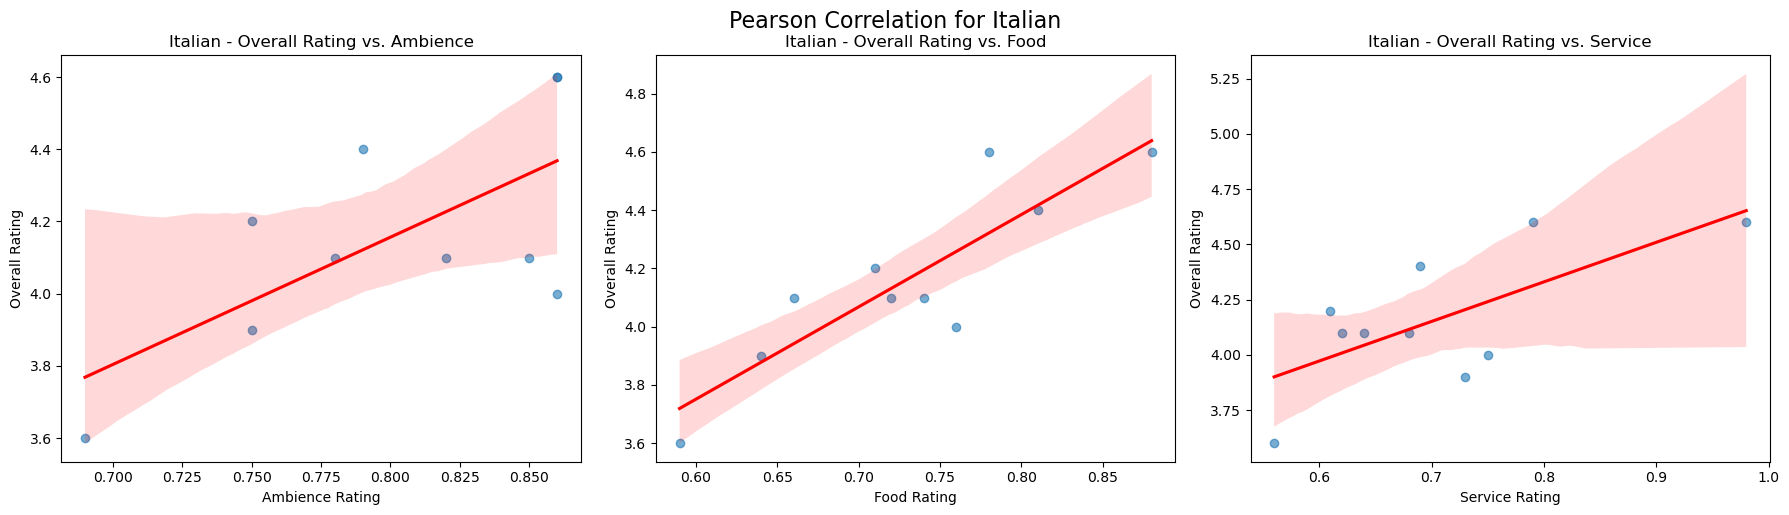

Scatter plots of Pearson correlations displayed.


In [ ]:
# Pearson Correlation Visualization: Scatterplots with regression lines to visualize the strength and direction of Pearson correlations for each attribute vs. overall rating

# Overall Pearson Correlation Scatter Plots
print("Overall Pearson Correlation Scatter Plots")
plt.figure(figsize=(18, 5))
for i, att in enumerate(attribute):
    plt.subplot(1, 3, i + 1)
    sns.regplot(x=df[att], y=df['overall_rating'], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    plt.title(f'Overall Rating vs. {att.replace("_rating", "").title()}')
    plt.xlabel(f'{att.replace("_rating", "").title()} Rating')
    plt.ylabel('Overall Rating')
plt.tight_layout()
plt.show()

# Cuisine-Specific Pearson Correlation Scatter Plots
print("\nCuisine-Specific Pearson Correlation Scatter Plots")
for cui in cuisine:
    cui_df = df[df['cuisine'] == cui]
    plt.figure(figsize=(18, 5))
    for i, att in enumerate(attribute):
        plt.subplot(1, 3, i + 1)
        sns.regplot(x=cui_df[att], y=cui_df['overall_rating'], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
        plt.title(f'{cui} - Overall Rating vs. {att.replace("_rating", "").title()}')
        plt.xlabel(f'{att.replace("_rating", "").title()} Rating')
        plt.ylabel('Overall Rating')
    plt.tight_layout()
    plt.suptitle(f'Pearson Correlation for {cui}', y=1.02, fontsize=16)
    plt.show()

print("Scatter plots of Pearson correlations displayed.")

Food quality shows the strongest positive correlation with overall rating. This pattern holds across most cuisines, with food quality showing the strongest correlations overall, except for Korean restaurants where ambience appears more influential.

# **R Squared Analysis**

In [ ]:
# Calculate r-squared values to measures how much variance in overall rating is explained by the attribute ratings, both overall and for each cuisine

print("Overall Rating")

X = df[attribute]
y = df['overall_rating']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print("r squared =", round(r2, 4))
print()

print("By Cuisine")

r2_result = []

for cui in cuisine:
    cui_df = df[df['cuisine'] == cui]

    X_cui = cui_df[attribute]
    y_cui = cui_df['overall_rating']

    model_cui = LinearRegression()
    model_cui.fit(X_cui, y_cui)
    y_pred_cui = model_cui.predict(X_cui)

    r2_cui = r2_score(y_cui, y_pred_cui)
    r2_result.append((cui, r2_cui))

    print(cui)
    print("r squared =", round(r2_cui, 4))
    print()

Overall Rating
r squared = 0.6369

By Cuisine
Vietnamese
r squared = 0.5237

Korean
r squared = 0.5166

Japanese
r squared = 0.8408

Mexican
r squared = 0.8886

Italian
r squared = 0.7775



C:\Users\Chrisgu\AppData\Local\Temp\ipykernel_33000\3794093555.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cuisine', y='R-squared Value', data=r2_df, palette='magma')


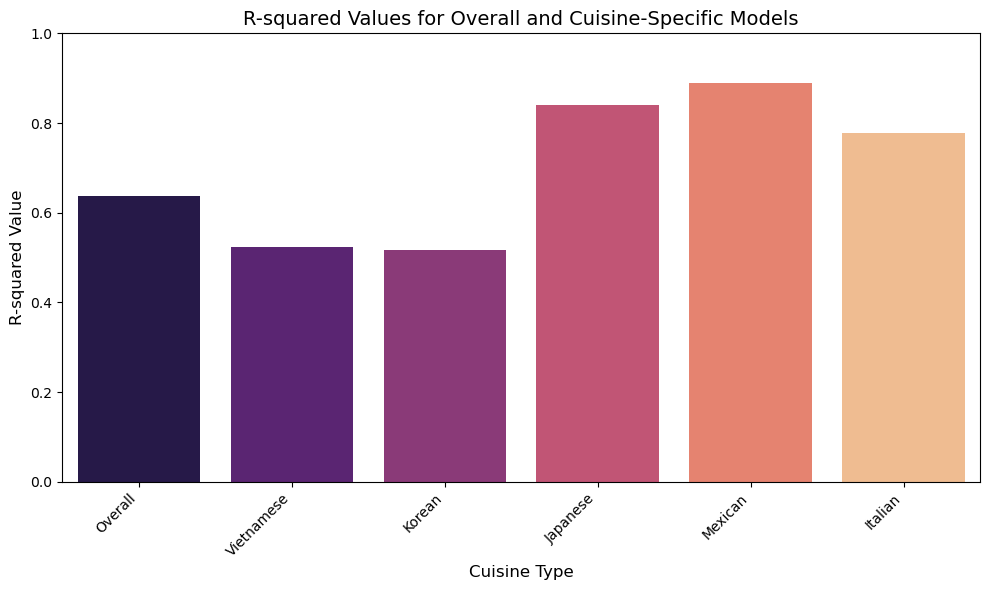

Bar chart of R-squared values displayed.


In [ ]:
# R Squared Visualization: Bar chart comparing r-squared values to show differences in model fit across cuisines

r2_overall_df = pd.DataFrame({
    'Cuisine': ['Overall'],
    'R-squared Value': [r2]
})

r2_data = []
for cui_name, r2_val in r2_result:
    r2_data.append({'Cuisine': cui_name, 'R-squared Value': r2_val})

r2_cuisine_df = pd.DataFrame(r2_data)
r2_df = pd.concat([r2_overall_df, r2_cuisine_df], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Cuisine', y='R-squared Value', data=r2_df, palette='magma')
plt.xlabel('Cuisine Type', fontsize=12)
plt.ylabel('R-squared Value', fontsize=12)
plt.title('R-squared Values for Overall and Cuisine-Specific Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("Bar chart of R-squared values displayed.")

R² values differ across cuisines, with Japanese and Mexican restaurants showing the highest explained variance in overall ratings.

# **Multiple Regression Analysis**

In [ ]:
# Fit multiple regression models to estimate the unique contribution of each attribute (ambience, food, service) to overall rating, controlling for the others

print("Overall Rating\n")

X = df[attribute]
y = df['overall_rating']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_.round(4))
print("Coefficients:")
print("Ambience =", model.coef_[0].round(4))
print("Food =", model.coef_[1].round(4))
print("Service =", model.coef_[2].round(4))

print("\nRegression Equation:")
print("Overall Rating =", model.intercept_.round(4), "+", model.coef_[0].round(4), "* ambience +", model.coef_[1].round(4), "* food +", model.coef_[2], "* service")
print()

# Run separate regression models for each cuisine to compare how attribute importance varies
print("By Cuisine")
for cui in cuisine:
    cui_df = df[df['cuisine'] == cui]

    X_cui = cui_df[attribute]
    y_cui = cui_df['overall_rating']

    model_cui = LinearRegression()
    model_cui.fit(X_cui, y_cui)

    print()
    print(cui)
    print("Intercept:", model_cui.intercept_.round(4))
    print("Coefficients:")
    print("Ambience:", model_cui.coef_[0].round(4))
    print("Food:", model_cui.coef_[1].round(4))
    print("Service:", model_cui.coef_[2].round(4))
    print(cui, "rating =", model_cui.intercept_.round(4), "+", model_cui.coef_[0].round(4), "* ambience +", model_cui.coef_[1].round(4), "* food +", model_cui.coef_[2].round(4), "* service")

Overall Rating

Intercept: 1.7145
Coefficients:
Ambience = 0.9687
Food = 2.4412
Service = -0.1922

Regression Equation:
Overall Rating = 1.7145 + 0.9687 * ambience + 2.4412 * food + -0.19219212362950855 * service

By Cuisine

Vietnamese
Intercept: 1.5015
Coefficients:
Ambience: 0.7559
Food: 2.8253
Service: -0.0701
Vietnamese rating = 1.5015 + 0.7559 * ambience + 2.8253 * food + -0.0701 * service

Korean
Intercept: 2.5808
Coefficients:
Ambience: 1.6138
Food: 0.6943
Service: -0.1006
Korean rating = 2.5808 + 1.6138 * ambience + 0.6943 * food + -0.1006 * service

Japanese
Intercept: 1.5701
Coefficients:
Ambience: 0.0468
Food: 3.1632
Service: 0.2342
Japanese rating = 1.5701 + 0.0468 * ambience + 3.1632 * food + 0.2342 * service

Mexican
Intercept: 2.1392
Coefficients:
Ambience: 0.244
Food: 2.0157
Service: 0.4537
Mexican rating = 2.1392 + 0.244 * ambience + 2.0157 * food + 0.4537 * service

Italian
Intercept: 1.4199
Coefficients:
Ambience: 0.9007
Food: 2.8557
Service: -0.0896
Italian rating 

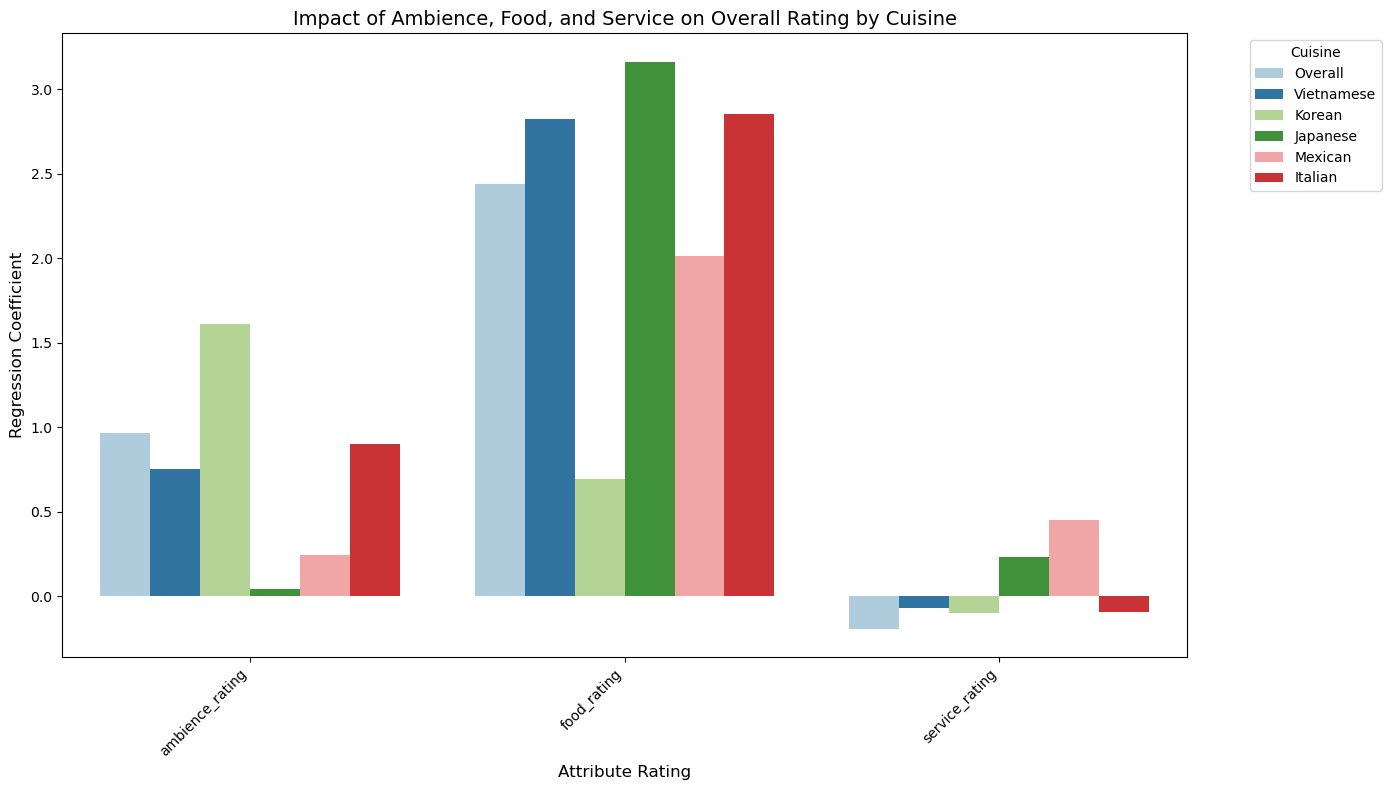

Bar chart of regression coefficients displayed.


In [ ]:
# Regression Visualization: Bar chart of regression coefficients showing how the impact of each attribute differs across cuisines

overall_coeff_df = pd.DataFrame({
    'Attribute': attribute,
    'Coefficient': model.coef_,
    'Cuisine': 'Overall'
})


cuisine_coefficients_list = []
for cui in cuisine:
    cui_df = df[df['cuisine'] == cui]
    X_cui = cui_df[attribute]
    y_cui = cui_df['overall_rating']
    model_cui = LinearRegression()
    model_cui.fit(X_cui, y_cui)

    cuisine_coefficients_list.append(pd.DataFrame({
        'Attribute': attribute,
        'Coefficient': model_cui.coef_,
        'Cuisine': cui
    }))

cuisine_coeff_df = pd.concat(cuisine_coefficients_list, ignore_index=True)


coeff_df = pd.concat([overall_coeff_df, cuisine_coeff_df], ignore_index=True)


plt.figure(figsize=(14, 8))
sns.barplot(x='Attribute', y='Coefficient', hue='Cuisine', data=coeff_df, palette='Paired')
plt.xlabel('Attribute Rating', fontsize=12)
plt.ylabel('Regression Coefficient', fontsize=12)
plt.title('Impact of Ambience, Food, and Service on Overall Rating by Cuisine', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cuisine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Bar chart of regression coefficients displayed.")

Across cuisines, food quality shows the strongest positive effect on overall ratings, while ambience and service play smaller and more variable roles depending on cuisine.